# Reinforcement learning algorithms

## Q-learning with ϵ-greedy exploration

We start out but importing some packages.

In [1]:
using OpenAIGym, BasisFunctionExpansions, ValueHistories, Plots

To be able to update the plots in the loop, we define the following function.

In [2]:
default(size=(800,600)) # Set the default plot size
function update_plot!(p; max_history = 10, attribute = :markercolor)
    num_series = length(p.series_list)
    if num_series > 1
        if num_series > max_history
            deleteat!(p.series_list,1:num_series-max_history)
        end
        for i = 1:min(max_history, num_series)-1
            alpha = 1-2/max_history
            c = p[i][attribute]
            b = alpha*c.b + (1-alpha)*0.5
            g = alpha*c.g + (1-alpha)*0.5
            r = alpha*c.r + (1-alpha)*0.5
            a = alpha*c.alpha
            p[i][attribute] = RGBA(r,g,b,a)
        end
    end
end

update_plot! (generic function with 1 method)

Next, we define an environment from the OpenAIGym framework

In [3]:
env = GymEnv("CartPole-v0")

[2017-02-19 21:48:03,003] Making new env: CartPole-v0


OpenAIGym.GymEnv("CartPole-v0",PyObject <TimeLimit<CartPoleEnv instance>>,[0.000175285,-0.00153645,0.0328858,0.0401101],0.0,LearnBase.DiscreteSet{UnitRange{Int64}}(0:1),false,#undef)

We also define a $Q$-function approximator that is a linear combination of radial basis functions. For this we make use of the package [`BasisFunctionExpansions.jl`](https://github.com/baggepinnen/BasisFunctionExpansions.jl). We use 4 basis functions along each dimension except for the action dimension, which is discrete with two values only.

In [4]:
bfe = MultiUniformRBFE([linspace(-0.3,0.3) linspace(-2,2) linspace(-0.2,0.2) linspace(-3.2,3.2) linspace(0,1)], [4,4,4,4,2])

type Qfun
    θ::Vector{Float64}
    bfe::MultiUniformRBFE
end

(Q::Qfun)(s,a) = Q.bfe([s;a])⋅Q.θ # This row makes our type Qfun callable

"""This function makes for a nice syntax of updating the Q-function"""
function Base.setindex!(Q::Qfun, q, s, a)
    Q.θ .+= Q.bfe([s;a])* q
end

const Q = Qfun(zeros(size(bfe.μ,2)), bfe) # Q is now our Q-function approximator

Qfun([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],BasisFunctionExpansions.MultiUniformRBFE{5}(BasisFunctionExpansions.#14,[-0.225 -0.225 … 0.225 0.225; -1.5 -1.5 … 1.5 1.5; … ; -2.4 -2.4 … 2.4 2.4; 0.25 0.75 … 0.25 0.75],[0.106066,0.707107,0.0707107,1.13137,0.353553]))

We move on by defining some parameters

In [5]:
num_episodes     = 400
α                = 1.    # Initial learning rate
const ϵ          = 0.5   # Initial chance of choosing random action
const decay_rate = 0.995 # decay rate for learning rate and ϵ
const γ          = 0.99  # Discounting factor

0.99

The next step is to define a `Reinforce.jl` policy type

In [6]:
type ϵGreedyPolicy <: AbstractPolicy
    ϵ::Float64
    decay_rate::Float64
end
"""Calling this function decays the ϵ"""
function decay!(policy::ϵGreedyPolicy)
    policy.ϵ *= policy.decay_rate
end
"""This is our ϵ-greedy action function"""
function Reinforce.action(policy::ϵGreedyPolicy, r, s, A)
    rand() < policy.ϵ ? rand(0:1) : Q(s,1) > Q(s,0) ? 1 : 0
end
"""This method is not required by Reinforce.jl, but we define it to be able to calculate an action witout random exploration"""
function Reinforce.action(policy::ϵGreedyPolicy, s)
    rand() < Q(s,1) > Q(s,0) ? 1 : 0
end

const policy = ϵGreedyPolicy(ϵ, decay_rate)

ϵGreedyPolicy(0.5,0.995)

We have now arrived at the main algorithm. We wrap it in a function for the Julia JIT complier to have it run faster.

In [7]:
pyplot() # Enable the pyplot backend, try gr insted if pyplot is slow
# gr()
fig = plot(layout=2)
plotting = false # Set to true to plot continuously
function Qlearning(num_episodes,α)
    reward_history = ValueHistories.History(Float64)
    for i = 1:num_episodes
        ep = Episode(env, policy)
        α *= decay_rate # Decay the learning rate
        decay!(policy) # Decay greedyness
        for (s::Vector{Float64},a::Int,r::Float64,s1::Vector{Float64}) in ep
            a1 = action(policy,s1)
            # i % 100 == 0 && OpenAIGym.render(env) # Uncomment this line to have the episode rendered
            Q[s,a] = α*(r + γ*Q(s1,a1) - Q(s,a)) # Update the Q-function approximator using Q-learning
        end
        push!(reward_history, i, ep.total_reward)
        i % 10 == 0 && println("Episode: $i, reward: $(ep.total_reward)")
        if plotting && i % 10 == 0
            plot!(reward_history, subplot=1)
            scatter!(Q.θ, subplot=2, c=:red)
            update_plot!(fig[1], max_history=1, attribute=:linecolor)
            update_plot!(fig[2], max_history=5, attribute=:linecolor)
            gui(fig)
        end
    end
    plot(reward_history, title="Rewards", xlabel="Episode", show=true)
end

Qlearning (generic function with 1 method)

We now call our function.

Episode: 10, reward: 79.0
Episode: 20, reward: 55.0
Episode: 30, reward: 43.0
Episode: 40, reward: 95.0
Episode: 50, reward: 91.0
Episode: 60, reward: 69.0
Episode: 70, reward: 60.0
Episode: 80, reward: 99.0
Episode: 90, reward: 55.0
Episode: 100, reward: 200.0
Episode: 110, reward: 200.0
Episode: 120, reward: 81.0
Episode: 130, reward: 31.0
Episode: 140, reward: 88.0
Episode: 150, reward: 18.0
Episode: 160, reward: 16.0
Episode: 170, reward: 146.0
Episode: 180, reward: 200.0
Episode: 190, reward: 200.0
Episode: 200, reward: 200.0
Episode: 210, reward: 200.0
Episode: 220, reward: 142.0
Episode: 230, reward: 200.0
Episode: 240, reward: 200.0
Episode: 250, reward: 200.0
Episode: 260, reward: 200.0
Episode: 270, reward: 200.0
Episode: 280, reward: 200.0
Episode: 290, reward: 200.0
Episode: 300, reward: 200.0
Episode: 310, reward: 200.0
Episode: 320, reward: 200.0
Episode: 330, reward: 200.0
Episode: 340, reward: 200.0
Episode: 350, reward: 200.0
Episode: 360, reward: 200.0
Episode: 370, r

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


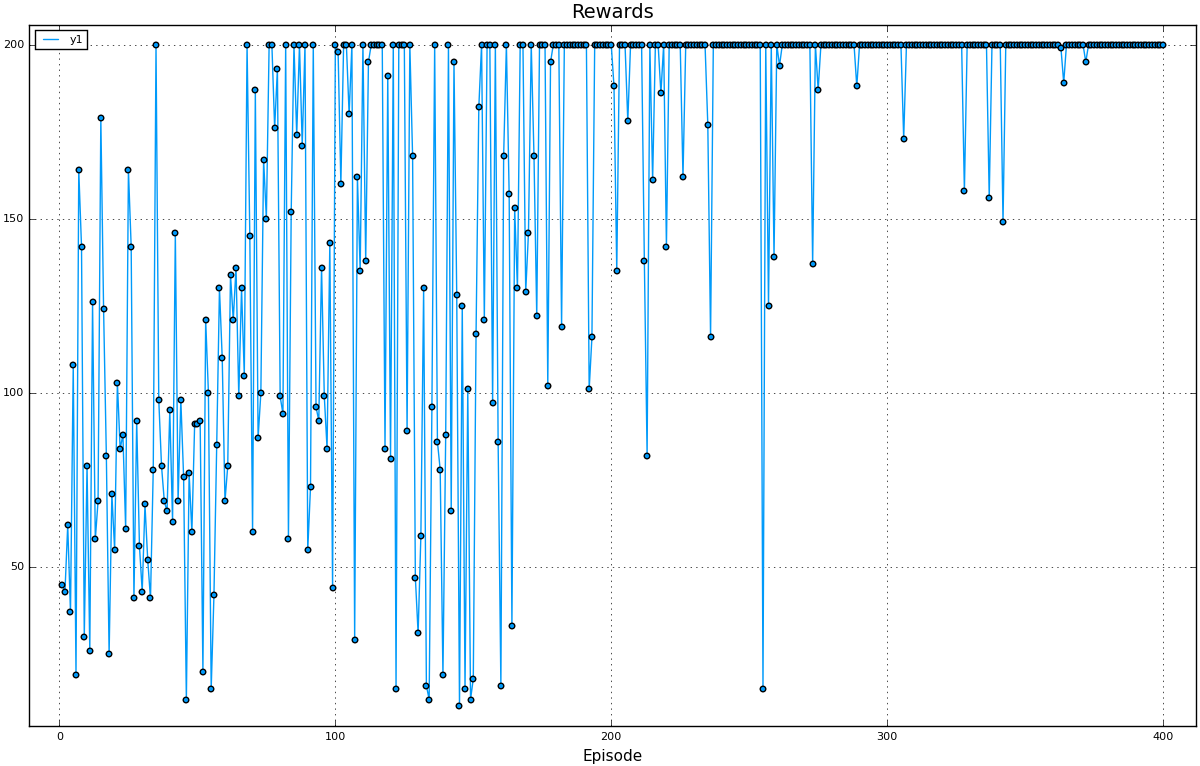

In [8]:
@time Qlearning(num_episodes,α)